<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Web APIs & NLP

# Modeling
---

## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re

from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier,
AdaBoostClassifier, VotingClassifier, StackingClassifier, ExtraTreesClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV,cross_val_predict
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, RocCurveDisplay)
from wordcloud import WordCloud, STOPWORDS

import warnings
warnings.filterwarnings("ignore")


In [135]:
df = pd.read_csv("../data/cleaned_data/conspiracy_news.csv")

## Final Preprocessing

In [137]:
lemmatizer = WordNetLemmatizer()

In [138]:
# Custom preprocessor
def custom_preprocessor(txt):
    txt = txt.lower()
    txt = txt.strip()
    txt = re.sub('\\n', '', txt) # remove new line
    txt = re.sub(r"[^\w\s]", "", txt) # remove special
    txt = re.findall("\w+", txt) #take only alphanumerical characters
    txt = [lemmatizer.lemmatize(i) for i in txt] # lemmatize
    txt = ' '.join(txt) # join list into string
    return txt

In [139]:
#apply preprocessing
df["title"] = df["title"].apply(custom_preprocessor)

In [140]:
# Make a list of stop words to add to english stop words
# Pass into Vectorizer Transformers
extra_words = ['just', 'like', 'us', 'get', 'going', 'would', 'one', 'people', 'video', 'covid',
              'new', '19', 'tucker', 'carlson']

# Append my list to english list
stop_list = stopwords.words("english") + extra_words

In [141]:
#binarize subreddit column
df["subreddit"] = df["subreddit"].map({"news":1, "conspiracy":0})

In [144]:
#Save preprocessed dataframe
df.to_csv("../data/cleaned_data/conspiracy_news_preprocessed.csv", index=False)

## Modeling
---

In [145]:
#import preprocessed dataframe
df = pd.read_csv("../data/cleaned_data/conspiracy_news_preprocessed.csv")

In [192]:
X = df["title"]
y = df["subreddit"]

In [193]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,stratify = y)

In [194]:
#Baseline
y_test.value_counts(normalize = True)

0    0.559837
1    0.440163
Name: subreddit, dtype: float64

**Baseline score signifies that if all posts were classified as conspiracy, accuracy would be approximately 56%.**

In [210]:
#provide model metrics
def model_evaluation(model, abbreviation):
    
    preds = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    train_acc = round(model.score(X_train, y_train),3)
    test_acc = round(model.score(X_test, y_test),3)
    sens = round(tp/(tp+fn),3)
    spec = round(tn/(tn+fp),3)
    prec = round(tp/(tp+fp),3)
    mis = round(1 - test_acc,3)
    f1 = round(f1_score(y_test, preds, pos_label = 1),3)
    
    print(f"Training Accuracy is: {train_acc}")
    print(f"Testing Accuracy is: {test_acc}")
    print(f'Sensitivity is: {sens}')
    print(f'Specificity is: {spec}')
    print(f'Precision is: {prec}')
    print(f'Misclassification Rate is: {mis}')
    print(f'F1 score is: {f1}')
    print()
    
    cm = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test,display_labels = ["conspiracy","news"])
    cm.figure_.savefig(f"../model_metrics/{abbreviation.replace(' ','_')}_matrix.png")
    
    
    data = {
        'Training Accuracy' : train_acc,
        'Testing Accuracy' : test_acc,
        'Sensitivity' : sens,
        'Specificity' : spec,
        'Precision' : prec,
        'Misclassification Rate' : mis,
        'F1 Score' : f1
    }
    
    return pd.DataFrame(data,index = [abbreviation])


In [190]:
def make_pipeline(model,vectorizer):
    pipe = Pipeline([
        ('vec', vectorizer),
        ('model', model)
    ])
    return pipe    

### Logistic Regression

In [195]:
pipe_logr = make_pipeline(LogisticRegression(max_iter=1000, random_state=42), TfidfVectorizer())

pipe_params_logr = {
    'vec__stop_words' : [None,stop_list],
    'vec__max_features': [2000,3000,4000,5000],
    'vec__min_df': [2,3,10],
    'vec__max_df': [.8,.9,.95,1],
    'model__penalty': [None,"l1","l2"],
    'model__solver' : ["saga"],
    'model__C' : [.01,.1,1,10] 
}

gs_logr = GridSearchCV(pipe_logr, param_grid = pipe_params_logr,cv = 5,n_jobs=-1)

gs_logr.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vec', TfidfVectorizer()),
                                       ('model',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'model__C': [0.01, 0.1, 1, 10],
                         'model__penalty': [None, 'l1', 'l2'],
                         'model__solver': ['saga'],
                         'vec__max_df': [0.8, 0.9, 0.95, 1],
                         'vec__max_features': [2000, 3000, 4000, 5000],
                         'vec__min_df': [2, 3, 10],
                         'vec__stop_words': [None,
                                             ['i', 'me', 'my', 'myself', 'we',
                                              'our', 'ours', 'ourselves', 'you',
                                              "you're", "you've", "you'll",
                                           

In [196]:
gs_logr.best_params_

{'model__C': 1,
 'model__penalty': 'l2',
 'model__solver': 'saga',
 'vec__max_df': 0.8,
 'vec__max_features': 5000,
 'vec__min_df': 2,
 'vec__stop_words': None}

Training Accuracy is: 0.892
Testing Accuracy is: 0.842
Sensitivity is: 0.826
Specificity is: 0.856
Precision is: 0.818
Misclassification Rate is: 0.158
F1 score is: 0.822



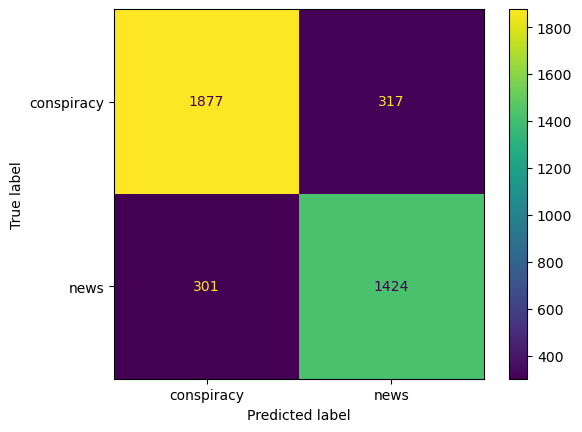

In [211]:
logr_results = model_evaluation(gs_logr, "Logistic Regression")

In [213]:
logr_results.to_csv("../model_metrics/logr_df.csv")

### Multinomial Naive Bayes

In [198]:
pipe_mnb = make_pipeline(MultinomialNB(), CountVectorizer())

pipe_params_mnb = {
    'vec__stop_words' : [None,stop_list],
    'vec__max_features': [2000,3000,4000,5000],
    'vec__min_df': [2,3,5,10],
    'vec__max_df': [.8,.9,.95,1],
    'model__alpha': [.01,.1,1,10],   
}

gs_mnb = GridSearchCV(pipe_mnb, param_grid = pipe_params_mnb,cv = 5,n_jobs=-1)

gs_mnb.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vec', CountVectorizer()),
                                       ('model', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'model__alpha': [0.01, 0.1, 1, 10],
                         'vec__max_df': [0.8, 0.9, 0.95, 1],
                         'vec__max_features': [2000, 3000, 4000, 5000],
                         'vec__min_df': [2, 3, 5, 10],
                         'vec__stop_words': [None,
                                             ['i', 'me', 'my', 'myself', 'we',
                                              'our', 'ours', 'ourselves', 'you',
                                              "you're", "you've", "you'll",
                                              "you'd", 'your', 'yours',
                                              'yourself', 'yourselves', 'he',
                                              'him', 'his', 'himself', 'she',
                                              "she's", 'h

In [199]:
gs_mnb.best_params_

{'model__alpha': 0.1,
 'vec__max_df': 0.8,
 'vec__max_features': 5000,
 'vec__min_df': 3,
 'vec__stop_words': None}

Training Accuracy is: 0.889
Testing Accuracy is: 0.848
Sensitivity is: 0.816
Specificity is: 0.872
Precision is: 0.834
Misclassification Rate is: 0.152
F1 score is: 0.825



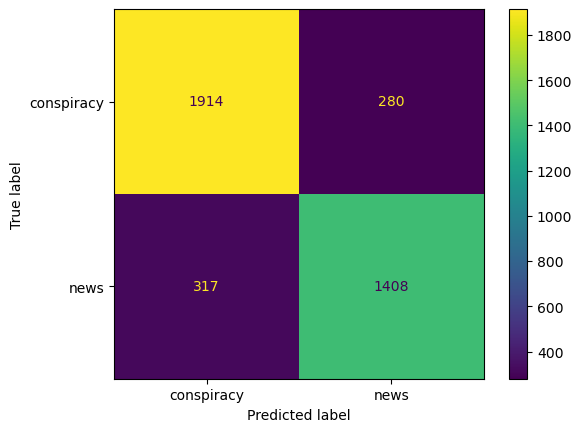

In [217]:
mnb_results = model_evaluation(gs_mnb,"Multinomial Naive Bayes")

In [215]:
mnb_results.to_csv("../model_metrics/mnb_df.csv")

### XGBoost

In [231]:
pipe_xgb = make_pipeline(XGBClassifier(random_state=42), TfidfVectorizer())

pipe_params_xgb = {
    'vec__stop_words' : [None,stop_list],
    'vec__max_features': [2000,3000,4000,5000],
    'vec__min_df': [2,3,5,10],
    'vec__max_df': [.8,.9,.95,1],
    'model__eta': [.1,.3,.5,.7],
    'model__max_depth': [5,6,7],
    
}

gs_xgb = GridSearchCV(pipe_xgb, param_grid = pipe_params_xgb,cv = 3,n_jobs=-1, )

gs_xgb.fit(X_train,y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vec', TfidfVectorizer()),
                                       ('model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None, gpu_id=None,
                                     

In [234]:
gs_xgb.best_params_

{'model__eta': 0.5,
 'model__max_depth': 7,
 'vec__max_df': 0.8,
 'vec__max_features': 4000,
 'vec__min_df': 2,
 'vec__stop_words': None}

Training Accuracy is: 0.9
Testing Accuracy is: 0.81
Sensitivity is: 0.792
Specificity is: 0.824
Precision is: 0.779
Misclassification Rate is: 0.19
F1 score is: 0.786



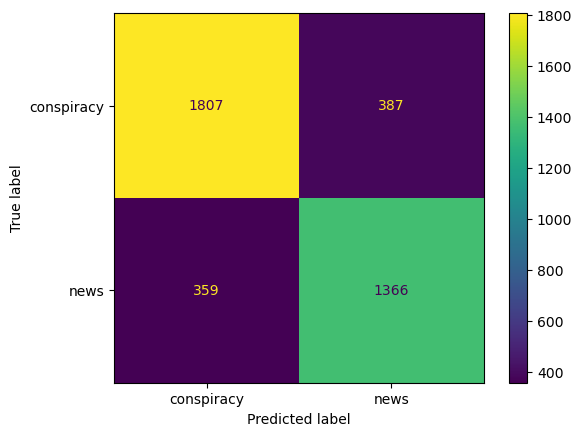

In [233]:
xgb_results = model_evaluation(gs_xgb, "XGB")

In [236]:
xgb_results.to_csv("../model_metrics/xgb_df.csv")

### Voting Classifier

In [238]:
vote = VotingClassifier([
    ('l', gs_logr),
    ('m', gs_mnb),
    ('x', gs_xgb)
])

vote.fit(X_train, y_train)

VotingClassifier(estimators=[('l',
                              GridSearchCV(cv=5,
                                           estimator=Pipeline(steps=[('vec',
                                                                      TfidfVectorizer()),
                                                                     ('model',
                                                                      LogisticRegression(max_iter=1000,
                                                                                         random_state=42))]),
                                           n_jobs=-1,
                                           param_grid={'model__C': [0.01, 0.1,
                                                                    1, 10],
                                                       'model__penalty': [None,
                                                                          'l1',
                                                                          'l2'],
      

Training Accuracy is: 0.902
Testing Accuracy is: 0.847
Sensitivity is: 0.829
Specificity is: 0.861
Precision is: 0.824
Misclassification Rate is: 0.153
F1 score is: 0.826



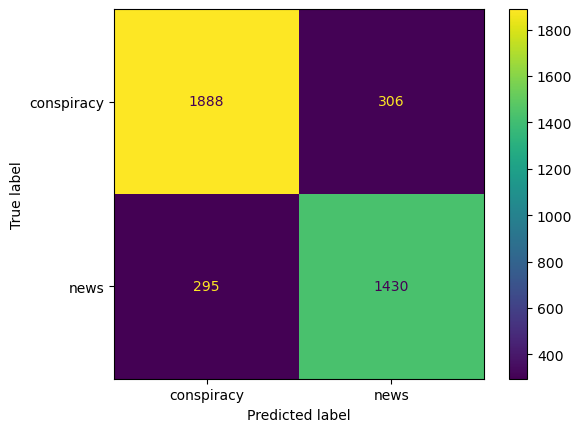

In [239]:
vote_results = model_evaluation(vote, "Vote")

In [240]:
vote_results.to_csv("../model_metrics/vote_df.csv")

## Analysis & Conclusion:
---

In [222]:
#analyze coeffcients of logistic regression
coef_features = pd.DataFrame(gs_logr.best_estimator_.named_steps['model'].coef_[0],
                             index = gs_logr.best_estimator_.named_steps['vec'].get_feature_names_out(), 
                             columns = ['coefficients'])

n_coef = coef_features.sort_values('coefficients', ascending = False)[: 10]

c_coef = coef_features.sort_values('coefficients')[: 10]

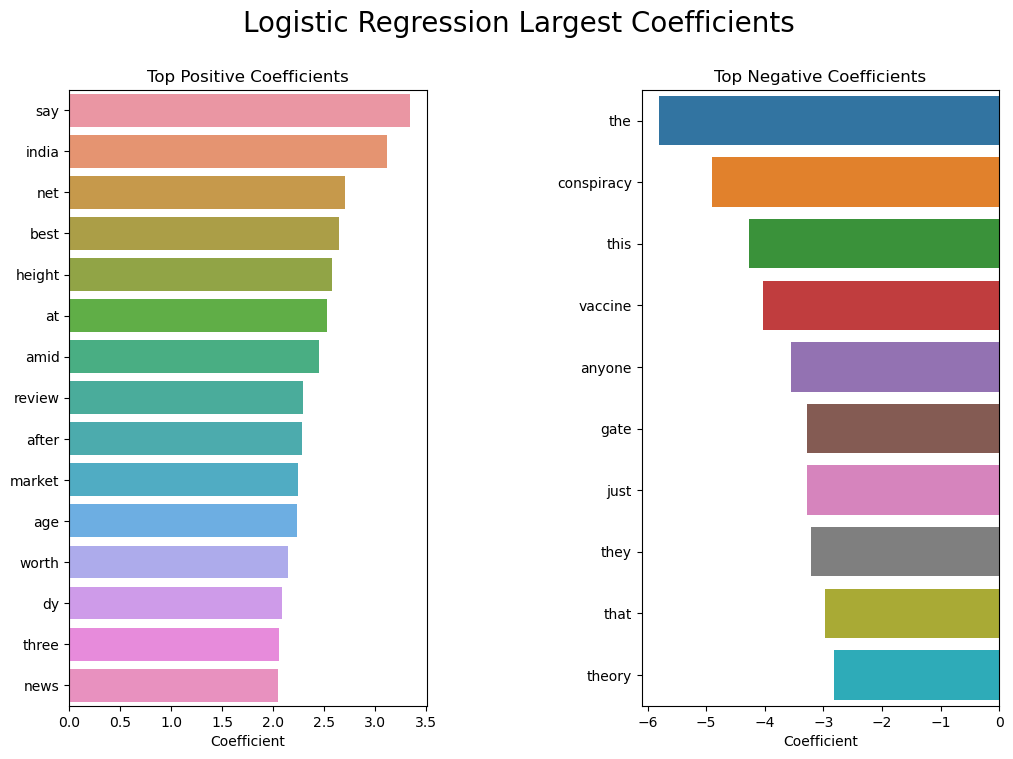

In [230]:
#plot largest and smallest probability coeffecients
fig, ax = plt.subplots(1, 2, figsize = (12, 8))

sns.barplot(x = n_coef.coefficients, y = n_coef.index, ax = ax[0])
sns.barplot(x = c_coef.coefficients, y = c_coef.index, ax = ax[1])

ax[0].set(title = 'Top Positive Coefficients', xlabel = 'Coefficient')
ax[1].set(title = 'Top Negative Coefficients', xlabel = 'Coefficient')

fig.suptitle('Logistic Regression Largest Coefficients', fontsize = 20)
plt.subplots_adjust(wspace=.6)
plt.savefig(f'../images/logr_coefficients.png');


Left plot list words that have highest odds to classify content as news whereas the right plot lists words that have highest chance to classify the content as conspiracy. 

In [241]:
results_df = pd.concat([logr_results,mnb_results,xgb_results,vote_results])
results_df.to_csv("../model_metrics/results_df.csv")
results_df.head()

,Training Accuracy,Testing Accuracy,Sensitivity,Specificity,Precision,Misclassification Rate,F1 Score
Logistic Regression,0.892,0.842,0.826,0.856,0.818,0.158,0.822
Multinomial Naive Bayes,0.889,0.848,0.816,0.872,0.834,0.152,0.825
XGB,0.900,0.810,0.792,0.824,0.779,0.190,0.786
Vote,0.902,0.847,0.829,0.861,0.824,0.153,0.826


The aim of this study was to build a classification model that could distinguish text from two chosen subreddits with high accuracy. The best model appears to be the Multinomail Naives Bayes Classifier. It has the highest testing accuracy and second highest F1 score. All models appear to be overfit, however. This most likely would be the model I choose to further modify and produce for business deployment. At the moment, it would not meet the demands of the Reddit moderation team due to the need of extremely high accuracy. However, the analysis of high probability words may help the staff more quickly judge the relevancty of posts. The accuracy, F1 score, and high variance can be further corrected by judicious feature selection and engineering, hyperparameter tuning, and further data collection. Additionally, exploring other models may prove to yield even superior metrics to the Bayes Classifier.